# Pitchbox detection 모델 구현

## 목표

경기 화면의 피치 트래커 (Pitch tracker box) 여부를 판별해 타석 상황임을 판별하는 모델 구축

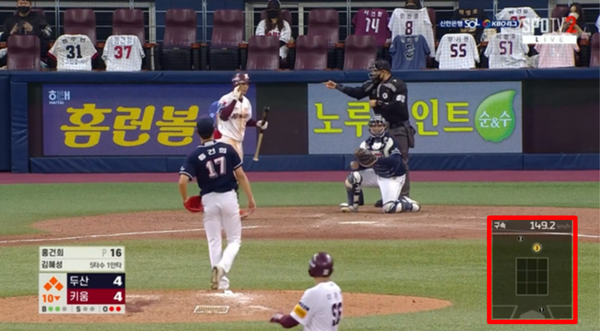

## 데이터셋 준비

Image segmentation 없이 Classification model로 우선 시도
- 174장의 캡쳐 이미지의 Pitchbox 여부에 따라 구분
- roboflow에서 이미지 labeling 및 데이터셋 구분 수행
- 640*640 resizing 수행

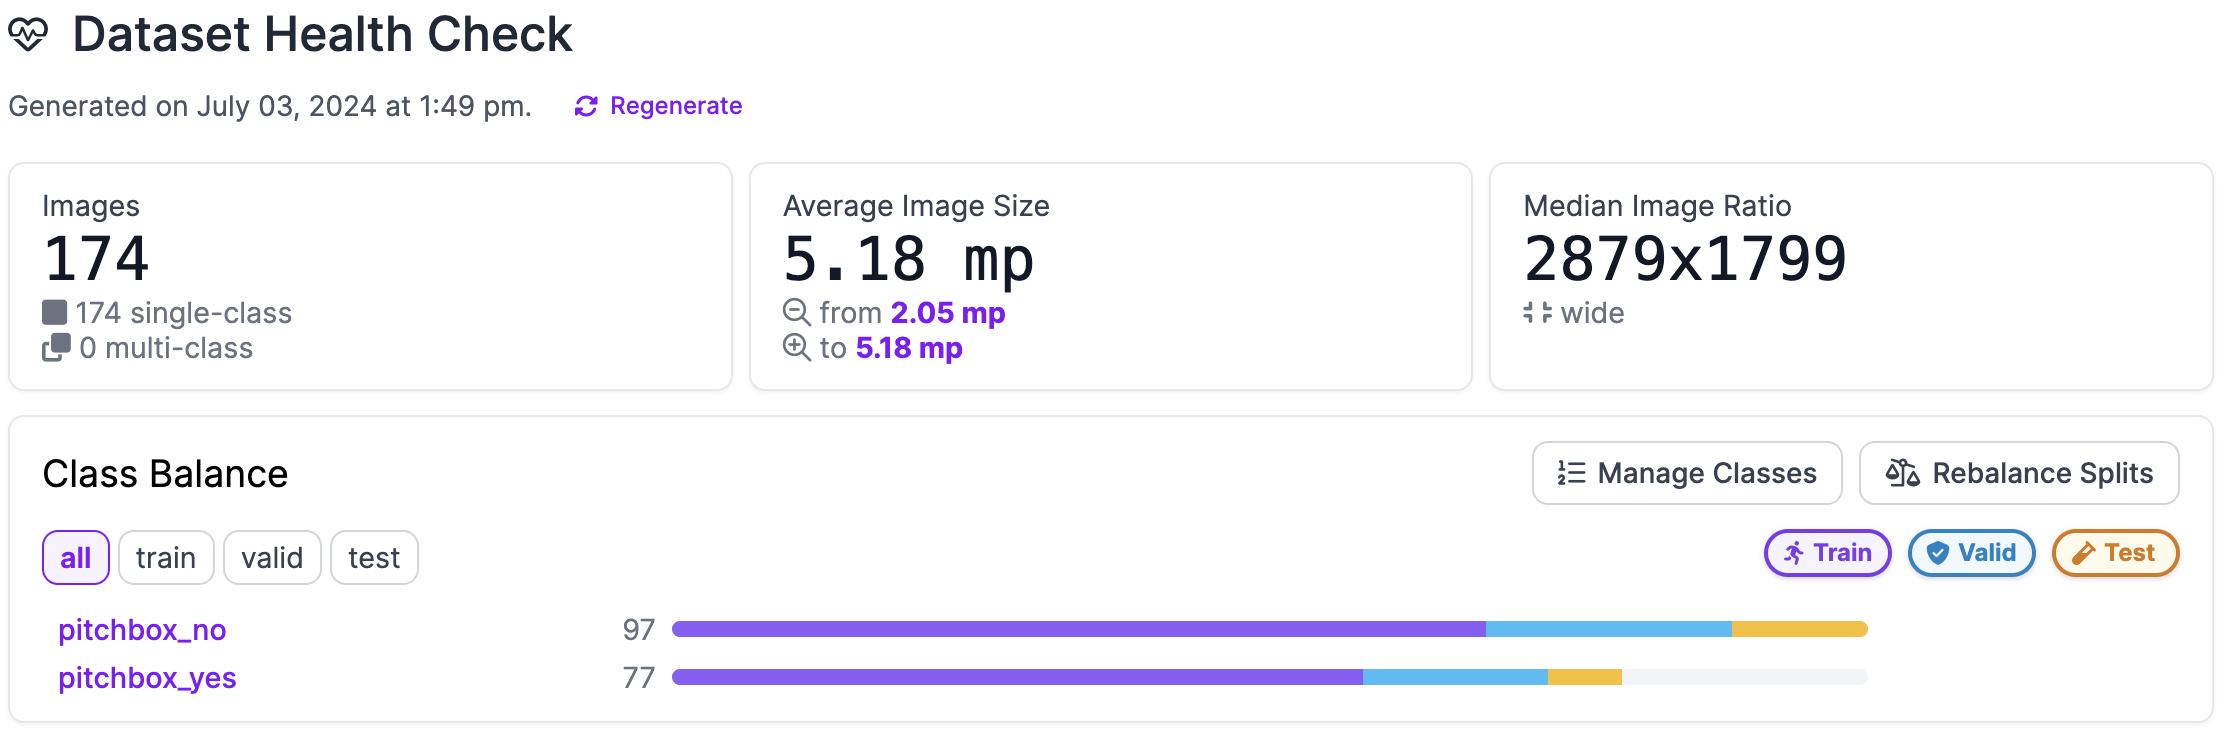

In [ ]:
# roboflow dataset download

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="NnuwZuFbKRJAmYF3Jue1")
project = rf.workspace("2024ksebpitchboxdetection").project("pitchbox_classification")
version = project.version(1)
dataset = version.download("folder")


In [ ]:
# 필요 라이브러리 설치
!pip install tensorflow opencv-python

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 경로 설정
train_dir = "./pitchbox_classification-1/train"
valid_dir = "./pitchbox_classification-1/valid"
test_dir = "./pitchbox_classification-1/test"

# 이미지 데이터 생성기 설정
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로딩
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

In [ ]:
# MobileNetV2 model과 imagenet pre-trained weight 적용
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# MobileNetV2 모델 불러오기 (사전 훈련된 가중치 사용, 최상위 층 제외)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 파인튜닝을 위한 모델 구성
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')  # 이진 분류를 위한 출력층
])

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 요약 정보 출력
model.summary()

In [ ]:
# 콜백 설정 (필요에 따라 조정 가능)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# 모델 훈련
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=20,
    callbacks=callbacks
)


In [ ]:
# 모델 평가 (steps_per_epoch 값 조정)
steps = max(1, test_generator.samples // test_generator.batch_size)
test_loss, test_accuracy = model.evaluate(test_generator, steps=steps)
print(f'Test Accuracy: {test_accuracy:.2f}')

## Real-time detection

In [ ]:
# 코랩 환경에서 cv2.imshow()는 에러 발생. 아래 코드는 cv2.imshow()를 cv2_imshow로 변경한 함수로, 주피터 환경이 아닌 경우에는 수정 필요
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Function to load video and process frames
def detect_pitch_tracker(video_path):
    cap = cv2.VideoCapture(video_path)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame for the model
        resized_frame = cv2.resize(frame, (224, 224))
        input_tensor = np.expand_dims(resized_frame, axis=0) / 255.0

        # Perform classification
        prediction = model.predict(input_tensor)

        # Display the result
        label = 'Pitch Tracker' if prediction[0] > 0.5 else 'No Pitch Tracker'
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2_imshow(frame)  # Use cv2_imshow instead of cv2.imshow

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Path to your video file
video_path = 'videoplayback_360p.mp4'
detect_pitch_tracker(video_path)


In [ ]:
# 10번째 프레임마다 모델에 넣어 판별하도록 변경 (프레임별 연산시간 30~40 ms)
# 동영상을 받아 결과를 영상 형태로 재구성해주는 코드
# 전체 영상이라 시간 많이 듬
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('best_model.h5')

# Function to load video, process frames, and save the result
def detect_pitch_tracker(video_path, output_path):
    cap = cv2.VideoCapture(video_path)

    # Get the width and height of the frames
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use other codecs like 'XVID'
    out = cv2.VideoWriter(output_path, fourcc, 20.0, (frame_width, frame_height))

    frame_count = 0
    label = 'No Pitch Tracker'  # Default label

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Analyze every 10th frame
        if frame_count % 10 == 0:
            # Preprocess the frame for the model
            resized_frame = cv2.resize(frame, (224, 224))
            input_tensor = np.expand_dims(resized_frame, axis=0) / 255.0

            # Perform classification
            prediction = model.predict(input_tensor)

            # Update the label
            label = 'Pitch Tracker' if prediction[0] > 0.5 else 'No Pitch Tracker'

        # Display the result
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write the frame into the output video file
        out.write(frame)

        # Optionally display the frame (comment out if not needed)
        # cv2_imshow(frame)  # Use cv2_imshow instead of cv2.imshow

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_count += 1

    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Path to your input video file
video_path = 'videoplayback_360p.mp4'
# Path to save the output video file
output_path = 'output_with_detection.mp4'

detect_pitch_tracker(video_path, output_path)

In [ ]:
# 4분 - 6분만 분석해주는 코드
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('best_model.h5')

# Function to load video, process frames, and save the result
def detect_pitch_tracker(video_path, output_path, start_minute, end_minute):
    cap = cv2.VideoCapture(video_path)

    # Get the frame rate of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate the start and end frames
    start_frame = int(start_minute * 60 * fps)
    end_frame = int(end_minute * 60 * fps)

    # Get the width and height of the frames
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use other codecs like 'XVID'
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frame_count = 0
    label = 'No Pitch Tracker'  # Default label

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Skip frames until the start frame
        if frame_count < start_frame:
            frame_count += 1
            continue

        # Stop processing after the end frame
        if frame_count > end_frame:
            break

        # Analyze every 10th frame
        if frame_count % 10 == 0:
            # Preprocess the frame for the model
            resized_frame = cv2.resize(frame, (224, 224))
            input_tensor = np.expand_dims(resized_frame, axis=0) / 255.0

            # Perform classification
            prediction = model.predict(input_tensor)

            # Update the label
            label = 'Pitch Tracker' if prediction[0] > 0.5 else 'No Pitch Tracker'

        # Display the result, change the font color
        color = (0, 0, 255) if label == 'Pitch Tracker' else (0, 255, 0)
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

        # Write the frame into the output video file
        out.write(frame)

        # Optionally display the frame (comment out if not needed)
        # cv2_imshow(frame)  # Use cv2_imshow instead of cv2.imshow

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_count += 1

    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Path to your input video file
video_path = 'videoplayback_360p.mp4'
# Path to save the output video file
output_path = 'output_with_detection.mp4'

# Define the start and end minutes
start_minute = 4
end_minute = 6

detect_pitch_tracker(video_path, output_path, start_minute, end_minute)



코랩 아닌 경우 사용할 코드 정리

In [ ]:
import cv2
import tensorflow as tf
import numpy as np

# Load the trained model
model = tf.keras.models.load_model('best_model.h5')

# Function to load video and process frames
def detect_pitch_tracker(video_path):
    cap = cv2.VideoCapture(video_path)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame for the model
        resized_frame = cv2.resize(frame, (224, 224))
        input_tensor = np.expand_dims(resized_frame, axis=0) / 255.0

        # Perform classification
        prediction = model.predict(input_tensor)

        # Display the result
        label = 'Pitch Tracker' if prediction[0] > 0.5 else 'No Pitch Tracker'
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow('Pitch Tracker Detection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# 실시간 감지 구현
# 'q'를 누르면 모델 종료

video_path = 'videoplayback_360p.mp4'
detect_pitch_tracker(video_path)

## 참고 링크

Roboflow 프로젝트 링크: https://app.roboflow.com/2024ksebpitchboxdetection/pitchbox_classification/1/export

Youtube URL 파일로 다운로드: https://ssyoutube.com/ko34aM/youtube-video-downloader